In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

### Data preparation, Data partitioning and normalization

In [2]:
class_name = 'Occupancy'
df1 = pd.read_csv('datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df2 =pd.read_csv('datatest.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df3=pd.read_csv('datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df4=pd.merge(df1, df2, how='outer')
df=pd.merge(df4, df3, how='outer')

In [3]:
df['Day']=pd.to_datetime(df['date']).dt.day
df['Hour']=pd.to_datetime(df['date']).dt.hour
df['Month']=pd.to_datetime(df['date']).dt.month
df['Year']=pd.to_datetime(df['date']).dt.year
df['Data']=pd.to_datetime(df['date']).dt.normalize()
del df['date']

In [4]:
df['Day']=df['Data'].dt.dayofweek
df.drop(['Year','Month','Data'], axis='columns', inplace=True)
del df['HumidityRatio']

In [5]:
from data_preparation import prepare_dataset

In [6]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,Day,Hour,Occupancy
0,23.18,27.2720,426.0,721.25,2,17,1
1,23.15,27.2675,429.5,714.00,2,17,1
2,23.15,27.2450,426.0,713.50,2,17,1
3,23.15,27.2000,426.0,708.25,2,17,1
4,23.10,27.2000,426.0,704.50,2,17,1


In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Single layer network

In [11]:
from sklearn.linear_model import Perceptron

In [12]:
sln=Perceptron()

In [13]:
sln.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
y_pred_sln = sln.predict(X_test)

In [15]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_sln))
print('F1-score %s' % f1_score(y_test, y_pred_sln, average=None))
print(classification_report(y_test, y_pred_sln))

Accuracy 0.9854085603112841
F1-score [0.99049028 0.96866295]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4743
           1       0.96      0.98      0.97      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.98      0.98      6168
weighted avg       0.99      0.99      0.99      6168



non posso fare roc curve ne lift chart perchè questo classificatore non ha clf.proba (Perceptrons do not output a class probability; rather,
they just make predictions based on a hard threshold. This is one of the good reasons to prefer Logistic
Regression over Perceptrons.)


## Multiple layer network

In [16]:
from sklearn.neural_network import MLPClassifier

In [21]:
mln = MLPClassifier(random_state=0)

mln.fit(X_train, y_train)

y_pred_mln = mln.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_mln))
print('F1-score %s' % f1_score(y_test, y_pred_mln, average=None))
print(classification_report(y_test, y_pred_mln))

Accuracy 0.9920557717250325
F1-score [0.99481317 0.98303911]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      1.00      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



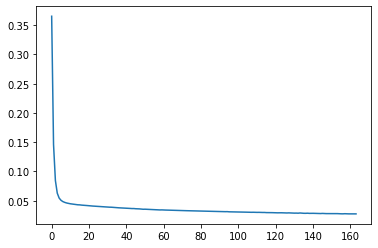

In [22]:
plt.plot(mln.loss_curve_)
plt.show()

non sembrano esserci problemi ne di overfitting ne di underfitting:
    - overfitting: The plot of training loss continues to decrease with experience or The plot of validation loss decreases to a point and begins increasing again.
    - underfitting:The training loss remains flat regardless of training or The training loss continues to decrease until the end of training.

This example visualizes some training loss curves for different stochastic learning strategies, including SGD and Adam. 

In [19]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning

constant learning-rate
training set score and loss: 0.769, 5.606281


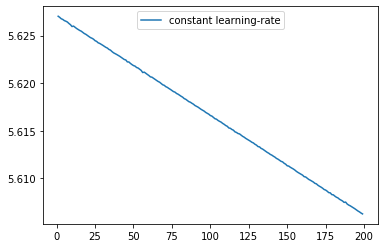

constant with momentum
training set score and loss: 0.769, 488.868846


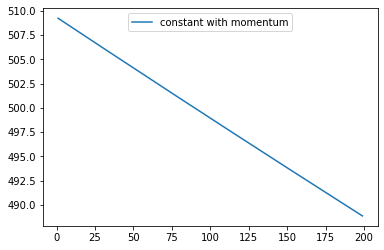

constant with Nesterov's momentum
training set score and loss: 0.769, 1603.213153


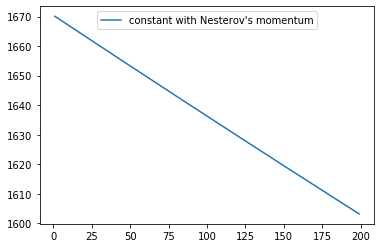

inv-scaling learning-rate
training set score and loss: 0.769, 5.627009


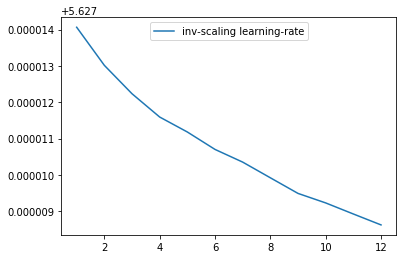

inv-scaling with momentum
training set score and loss: 0.769, 1670.178766


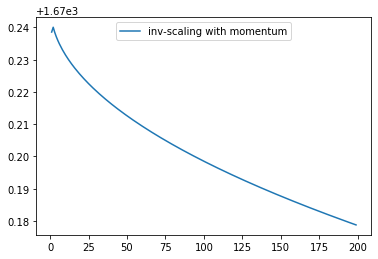

inv-scaling with Nesterov's momentum
training set score and loss: 0.769, 509.280629


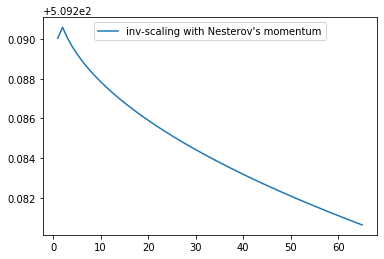

adam
training set score and loss: 0.990, 0.051007


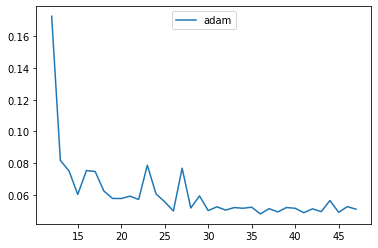

In [21]:
for label, param in zip(labels, params):
    print(label)
    mlp = MLPClassifier(random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp.fit(X, y)

    print("training set score and loss: %.3f, %f" % (mlp.score(X, y), mlp.loss_))
    plt.plot(mlp.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

 le strategie portano ad overfitting: le prime sei perche la loss curve continuano a decrescere con l'esperienza

## keras DNN

In [24]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [25]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

-The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.(The batch size is a number of samples processed before the model is updated)


-The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.(The number of epochs is the number of complete passes through the training dataset)

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [29]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=100, batch_size=30).history

Epoch 1/100
14392/14392 [==============================] - 1s 77us/step - loss: 0.0799 - accuracy: 0.9806
Epoch 2/100
14392/14392 [==============================] - 1s 56us/step - loss: 0.0415 - accuracy: 0.9892
Epoch 3/100
14392/14392 [==============================] - 1s 53us/step - loss: 0.0392 - accuracy: 0.9892
Epoch 4/100
14392/14392 [==============================] - 1s 53us/step - loss: 0.0375 - accuracy: 0.9894
Epoch 5/100
14392/14392 [==============================] - 1s 53us/step - loss: 0.0363 - accuracy: 0.9895
Epoch 6/100
14392/14392 [==============================] - 1s 54us/step - loss: 0.0345 - accuracy: 0.9894
Epoch 7/100
14392/14392 [==============================] - 1s 54us/step - loss: 0.0333 - accuracy: 0.9894
Epoch 8/100
14392/14392 [==============================] - 1s 53us/step - loss: 0.0315 - accuracy: 0.9898
Epoch 9/100
14392/14392 [==============================] - 1s 53us/step - loss: 0.0306 - accuracy: 0.9899
Epoch 10/100
14392/14392 [====================

14392/14392 [==============================] - 1s 53us/step - loss: 0.0220 - accuracy: 0.9922
Epoch 78/100
14392/14392 [==============================] - 1s 51us/step - loss: 0.0223 - accuracy: 0.9924
Epoch 79/100
14392/14392 [==============================] - 1s 50us/step - loss: 0.0223 - accuracy: 0.9924
Epoch 80/100
14392/14392 [==============================] - 1s 51us/step - loss: 0.0217 - accuracy: 0.9918
Epoch 81/100
14392/14392 [==============================] - 1s 49us/step - loss: 0.0221 - accuracy: 0.9922
Epoch 82/100
14392/14392 [==============================] - 1s 49us/step - loss: 0.0223 - accuracy: 0.9919
Epoch 83/100
14392/14392 [==============================] - 1s 51us/step - loss: 0.0215 - accuracy: 0.9925
Epoch 84/100
14392/14392 [==============================] - 1s 60us/step - loss: 0.0216 - accuracy: 0.9922
Epoch 85/100
14392/14392 [==============================] - 1s 61us/step - loss: 0.0220 - accuracy: 0.9917
Epoch 86/100
14392/14392 [========================

In [30]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=100, batch_size=100).history

Epoch 1/100
14392/14392 [==============================] - 0s 32us/step - loss: 0.1453 - accuracy: 0.9573
Epoch 2/100
14392/14392 [==============================] - 0s 20us/step - loss: 0.0455 - accuracy: 0.9891
Epoch 3/100
14392/14392 [==============================] - 0s 19us/step - loss: 0.0423 - accuracy: 0.9893
Epoch 4/100
14392/14392 [==============================] - 0s 18us/step - loss: 0.0410 - accuracy: 0.9893
Epoch 5/100
14392/14392 [==============================] - 0s 18us/step - loss: 0.0394 - accuracy: 0.9893
Epoch 6/100
14392/14392 [==============================] - 0s 18us/step - loss: 0.0386 - accuracy: 0.9892
Epoch 7/100
14392/14392 [==============================] - 0s 19us/step - loss: 0.0374 - accuracy: 0.9894
Epoch 8/100
14392/14392 [==============================] - 0s 20us/step - loss: 0.0369 - accuracy: 0.9894
Epoch 9/100
14392/14392 [==============================] - 0s 20us/step - loss: 0.0359 - accuracy: 0.9894
Epoch 10/100
14392/14392 [====================

14392/14392 [==============================] - 0s 19us/step - loss: 0.0234 - accuracy: 0.9916
Epoch 78/100
14392/14392 [==============================] - 0s 18us/step - loss: 0.0224 - accuracy: 0.9922
Epoch 79/100
14392/14392 [==============================] - 0s 18us/step - loss: 0.0229 - accuracy: 0.9920
Epoch 80/100
14392/14392 [==============================] - 0s 18us/step - loss: 0.0230 - accuracy: 0.9919
Epoch 81/100
14392/14392 [==============================] - 0s 19us/step - loss: 0.0232 - accuracy: 0.9919
Epoch 82/100
14392/14392 [==============================] - 0s 20us/step - loss: 0.0221 - accuracy: 0.9920
Epoch 83/100
14392/14392 [==============================] - 0s 19us/step - loss: 0.0227 - accuracy: 0.9916
Epoch 84/100
14392/14392 [==============================] - 0s 20us/step - loss: 0.0230 - accuracy: 0.9918
Epoch 85/100
14392/14392 [==============================] - 0s 20us/step - loss: 0.0223 - accuracy: 0.9914
Epoch 86/100
14392/14392 [========================

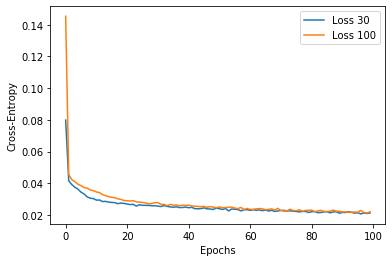

In [31]:
plt.plot(history1['loss'], label='Loss 30')
plt.plot(history2['loss'], label='Loss 100')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [32]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 0s 24us/step
Loss 0.028199, Accuracy 0.991732
Loss 0.029829, Accuracy 0.991407


In [42]:
y_pred = model2.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7691309987029832
F1-score [0.86947754 0.00140252]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4743
           1       1.00      0.00      0.00      1425

    accuracy                           0.77      6168
   macro avg       0.88      0.50      0.44      6168
weighted avg       0.82      0.77      0.67      6168



In [33]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100).history

Train on 14392 samples, validate on 6168 samples
Epoch 1/200
14392/14392 [==============================] - 1s 39us/step - loss: 0.1265 - accuracy: 0.9750 - val_loss: 0.0417 - val_accuracy: 0.9909
Epoch 2/200
14392/14392 [==============================] - 0s 25us/step - loss: 0.0443 - accuracy: 0.9891 - val_loss: 0.0363 - val_accuracy: 0.9912
Epoch 3/200
14392/14392 [==============================] - 0s 27us/step - loss: 0.0415 - accuracy: 0.9892 - val_loss: 0.0346 - val_accuracy: 0.9914
Epoch 4/200
14392/14392 [==============================] - 0s 27us/step - loss: 0.0402 - accuracy: 0.9893 - val_loss: 0.0336 - val_accuracy: 0.9914
Epoch 5/200
14392/14392 [==============================] - 0s 26us/step - loss: 0.0389 - accuracy: 0.9894 - val_loss: 0.0333 - val_accuracy: 0.9914
Epoch 6/200
14392/14392 [==============================] - 0s 24us/step - loss: 0.0382 - accuracy: 0.9893 - val_loss: 0.0332 - val_accuracy: 0.9914
Epoch 7/200
14392/14392 [==============================] - 0s 2

Epoch 56/200
14392/14392 [==============================] - 0s 21us/step - loss: 0.0237 - accuracy: 0.9921 - val_loss: 0.0279 - val_accuracy: 0.9932
Epoch 57/200
14392/14392 [==============================] - 0s 21us/step - loss: 0.0237 - accuracy: 0.9915 - val_loss: 0.0281 - val_accuracy: 0.9927
Epoch 58/200
14392/14392 [==============================] - 0s 22us/step - loss: 0.0237 - accuracy: 0.9924 - val_loss: 0.0276 - val_accuracy: 0.9929
Epoch 59/200
14392/14392 [==============================] - 0s 22us/step - loss: 0.0236 - accuracy: 0.9917 - val_loss: 0.0286 - val_accuracy: 0.9914
Epoch 60/200
14392/14392 [==============================] - 0s 23us/step - loss: 0.0237 - accuracy: 0.9915 - val_loss: 0.0294 - val_accuracy: 0.9909
Epoch 61/200
14392/14392 [==============================] - 0s 23us/step - loss: 0.0232 - accuracy: 0.9919 - val_loss: 0.0274 - val_accuracy: 0.9922
Epoch 62/200
14392/14392 [==============================] - 0s 24us/step - loss: 0.0231 - accuracy: 0.9926

14392/14392 [==============================] - 0s 20us/step - loss: 0.0206 - accuracy: 0.9924 - val_loss: 0.0272 - val_accuracy: 0.9925
Epoch 111/200
14392/14392 [==============================] - 0s 19us/step - loss: 0.0213 - accuracy: 0.9919 - val_loss: 0.0281 - val_accuracy: 0.9922
Epoch 112/200
14392/14392 [==============================] - 0s 20us/step - loss: 0.0208 - accuracy: 0.9920 - val_loss: 0.0274 - val_accuracy: 0.9921
Epoch 113/200
14392/14392 [==============================] - 0s 20us/step - loss: 0.0208 - accuracy: 0.9919 - val_loss: 0.0255 - val_accuracy: 0.9932
Epoch 114/200
14392/14392 [==============================] - 0s 21us/step - loss: 0.0211 - accuracy: 0.9917 - val_loss: 0.0266 - val_accuracy: 0.9930
Epoch 115/200
14392/14392 [==============================] - 0s 20us/step - loss: 0.0208 - accuracy: 0.9924 - val_loss: 0.0281 - val_accuracy: 0.9921
Epoch 116/200
14392/14392 [==============================] - 0s 21us/step - loss: 0.0202 - accuracy: 0.9921 - val_

Epoch 165/200
14392/14392 [==============================] - 0s 20us/step - loss: 0.0190 - accuracy: 0.9929 - val_loss: 0.0273 - val_accuracy: 0.9932
Epoch 166/200
14392/14392 [==============================] - 0s 19us/step - loss: 0.0194 - accuracy: 0.9921 - val_loss: 0.0264 - val_accuracy: 0.9934
Epoch 167/200
14392/14392 [==============================] - 0s 19us/step - loss: 0.0188 - accuracy: 0.9933 - val_loss: 0.0288 - val_accuracy: 0.9909
Epoch 168/200
14392/14392 [==============================] - 0s 19us/step - loss: 0.0188 - accuracy: 0.9931 - val_loss: 0.0303 - val_accuracy: 0.9922
Epoch 169/200
14392/14392 [==============================] - 0s 25us/step - loss: 0.0191 - accuracy: 0.9924 - val_loss: 0.0270 - val_accuracy: 0.9925
Epoch 170/200
14392/14392 [==============================] - 0s 21us/step - loss: 0.0189 - accuracy: 0.9926 - val_loss: 0.0283 - val_accuracy: 0.9925
Epoch 171/200
14392/14392 [==============================] - 0s 21us/step - loss: 0.0191 - accuracy:

In [36]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

6168/6168 [==============================] - 0s 28us/step
Loss 0.028199, Accuracy 0.991732
Loss 0.029829, Accuracy 0.991407
Loss 0.028715, Accuracy 0.992380


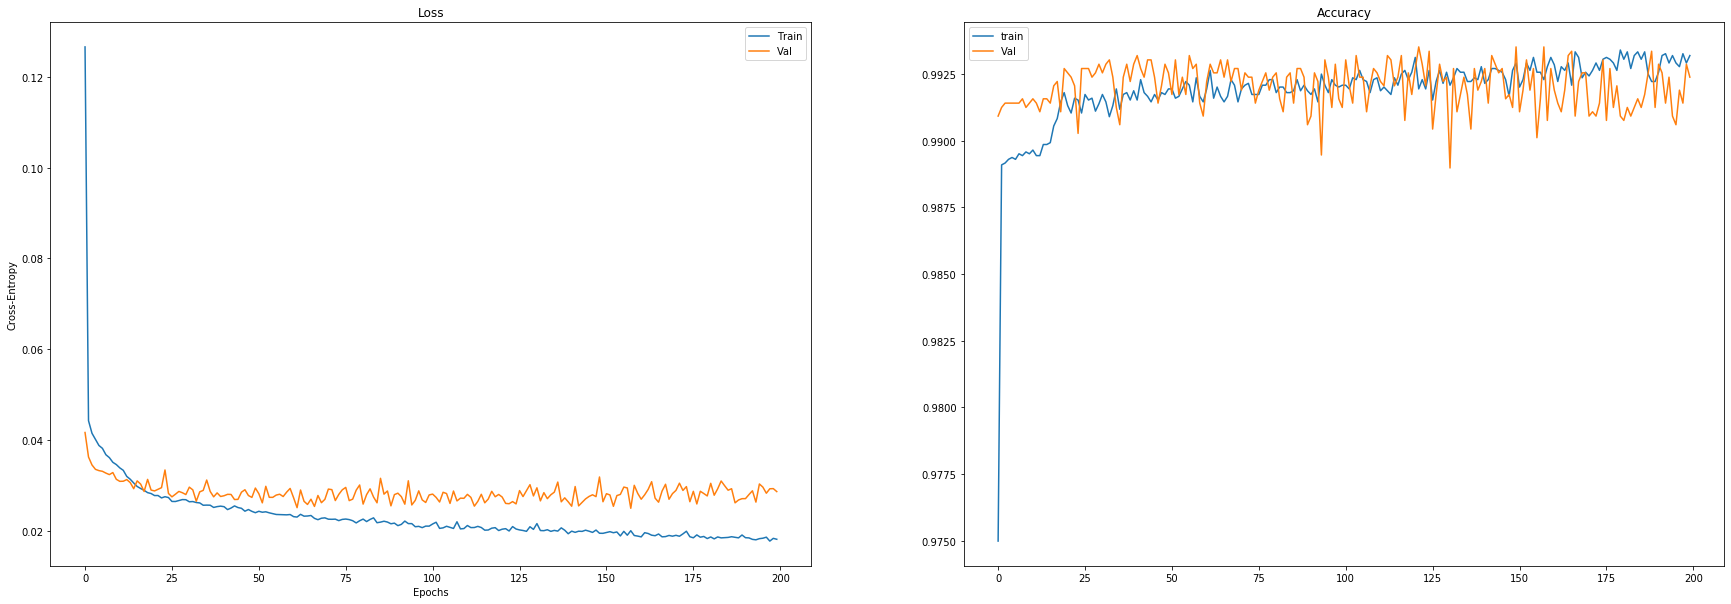

In [40]:
fig = plt.figure(figsize=(30, 10)) 
fig_dims = (1, 2)

#plot loss during training
plt.subplot2grid(fig_dims, (0, 0))
plt.title('Loss')
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
#plt.show()

# plot accuracy during training
plt.subplot2grid(fig_dims, (0,1))
plt.title('Accuracy')
plt.plot(history3['accuracy'], label='train')
plt.plot(history3['val_accuracy'], label='Val')
plt.legend()
#plt.show()

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Early stopping

In [44]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, 
                      batch_size=100, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/200
11513/11513 [==============================] - 0s 38us/step - loss: 0.1488 - accuracy: 0.9700 - val_loss: 0.0500 - val_accuracy: 0.9882
Epoch 2/200
11513/11513 [==============================] - 0s 22us/step - loss: 0.0459 - accuracy: 0.9893 - val_loss: 0.0450 - val_accuracy: 0.9892
Epoch 3/200
11513/11513 [==============================] - 0s 22us/step - loss: 0.0426 - accuracy: 0.9893 - val_loss: 0.0442 - val_accuracy: 0.9885
Epoch 4/200
11513/11513 [==============================] - 0s 24us/step - loss: 0.0412 - accuracy: 0.9894 - val_loss: 0.0421 - val_accuracy: 0.9889
Epoch 5/200
11513/11513 [==============================] - 0s 25us/step - loss: 0.0407 - accuracy: 0.9893 - val_loss: 0.0416 - val_accuracy: 0.9889
Epoch 6/200
11513/11513 [==============================] - 0s 23us/step - loss: 0.0394 - accuracy: 0.9894 - val_loss: 0.0410 - val_accuracy: 0.9889
Epoch 7/200
11513/11513 [==============================] - 0s 2

In [56]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

6168/6168 [==============================] - 0s 24us/step
Loss 0.028199, Accuracy 0.991732
Loss 0.029829, Accuracy 0.991407
Loss 0.028715, Accuracy 0.992380
Loss 0.030221, Accuracy 0.992380


## L2 regularization

In [48]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [54]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, 
                    batch_size=100, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/200
11513/11513 [==============================] - 1s 64us/step - loss: 2.1482 - accuracy: 0.9176 - val_loss: 1.2515 - val_accuracy: 0.9479
Epoch 2/200
11513/11513 [==============================] - 0s 35us/step - loss: 0.9176 - accuracy: 0.9385 - val_loss: 0.6919 - val_accuracy: 0.9531
Epoch 3/200
11513/11513 [==============================] - 0s 33us/step - loss: 0.5508 - accuracy: 0.9499 - val_loss: 0.4220 - val_accuracy: 0.9774
Epoch 4/200
11513/11513 [==============================] - 0s 33us/step - loss: 0.3784 - accuracy: 0.9606 - val_loss: 0.3152 - val_accuracy: 0.9729
Epoch 5/200
11513/11513 [==============================] - 0s 35us/step - loss: 0.2827 - accuracy: 0.9699 - val_loss: 0.2322 - val_accuracy: 0.9837
Epoch 6/200
11513/11513 [==============================] - 0s 38us/step - loss: 0.2236 - accuracy: 0.9769 - val_loss: 0.2218 - val_accuracy: 0.9705
Epoch 7/200
11513/11513 [==============================] - 0s 3

In [50]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [53]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=200, batch_size=100, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/200
11513/11513 [==============================] - 1s 84us/step - loss: 0.1971 - accuracy: 0.5194 - val_loss: 0.1603 - val_accuracy: 0.1643
Epoch 2/200
11513/11513 [==============================] - 1s 46us/step - loss: 0.1557 - accuracy: 0.2086 - val_loss: 0.1550 - val_accuracy: 0.0240
Epoch 3/200
11513/11513 [==============================] - 1s 45us/step - loss: 0.1594 - accuracy: 0.1233 - val_loss: 0.1500 - val_accuracy: 0.0257
Epoch 4/200
11513/11513 [==============================] - 1s 45us/step - loss: 0.1551 - accuracy: 0.0745 - val_loss: 0.1652 - val_accuracy: 0.0049
Epoch 5/200
11513/11513 [==============================] - 1s 45us/step - loss: 0.1597 - accuracy: 0.0545 - val_loss: 0.1494 - val_accuracy: 0.0024
Epoch 6/200
11513/11513 [==============================] - 1s 46us/step - loss: 0.1623 - accuracy: 0.0360 - val_loss: 0.1495 - val_accuracy: 0.0014
Epoch 7/200
11513/11513 [==============================] - 1s 4

In [57]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

6168/6168 [==============================] - 0s 38us/step


In [58]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.030018, Accuracy 0.992380
Loss 0.096211, Accuracy 0.991245
Loss 0.126610, Accuracy 0.004377


## Hyper-Parameter Tuning

In [66]:
from keras.wrappers.scikit_learn import KerasRegressor #which implements the Scikit-Learn regressor interface
from sklearn.model_selection import RandomizedSearchCV

In [67]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [68]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [69]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=200, batch_size=100, verbose=0)

3837/3837 [==============================] - 0s 22us/step


In [64]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.062114 using {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 32, 'activation': 'tanh'}
0.079585 (0.026060) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 32, 'activation': 'relu'}
0.089362 (0.009124) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 128, 'activation': 'tanh'}
0.138012 (0.094906) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 32, 'activation': 'tanh'}
0.062114 (0.013748) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 32, 'activation': 'tanh'}
0.100799 (0.039294) with: {'optimizer': 'adagrad', 'n_layers': 3, 'h_dim': 32, 'activation': 'tanh'}


In [65]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

6168/6168 [==============================] - 0s 23us/step
Loss 0.119694, Accuracy 0.008755


https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53

In [ ]:
y_pred= clf.predict(X_test)

